In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pgeocode
import us
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from imblearn.over_sampling import SMOTE
# Suprimir futuros avisos relacionados con el parámetro 'sparse' en OneHotEncoder
warnings.filterwarnings("ignore")


# Limpiamos Telco_customer_churn_status.csv**

In [2]:
# Ruta del archivo ZIP
zip_file_path = "Churn.zip"
csv_filename = "Telco_customer_churn_status.csv"  # Nombre del archivo CSV dentro del ZIP

# Leer el archivo CSV directamente desde el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Mostrar las primeras filas para verificar que se ha leído correctamente
df.head()


,Customer ID,Count,Quarter,Customer Status,Churn Label,Churn Value,Churn Category,Churn Reason
0,8779-QRDMV,1,Q3,Churned,Yes,1,Competitor,Competitor offered more data
1,7495-OOKFY,1,Q3,Churned,Yes,1,Competitor,Competitor made better offer
2,1658-BYGOY,1,Q3,Churned,Yes,1,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Q3,Churned,Yes,1,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Q3,Churned,Yes,1,Price,Extra data charges


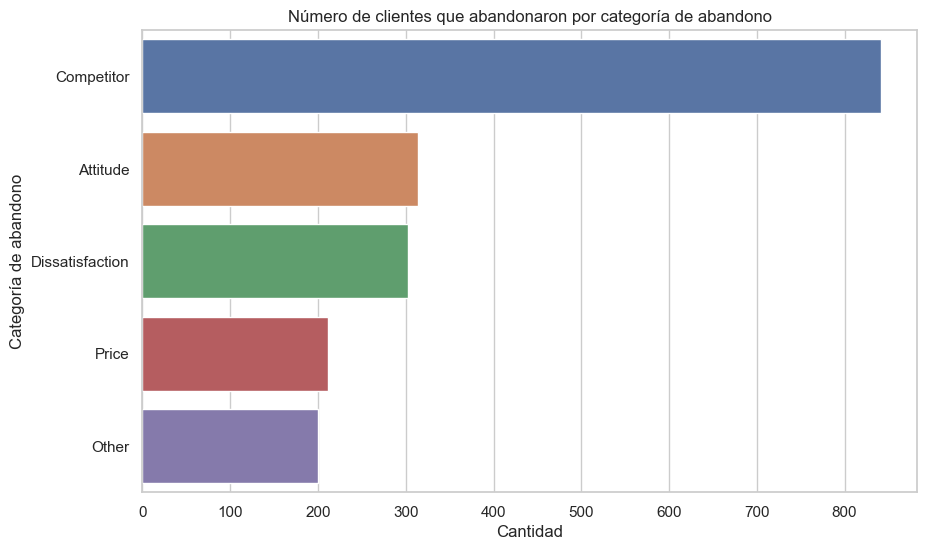

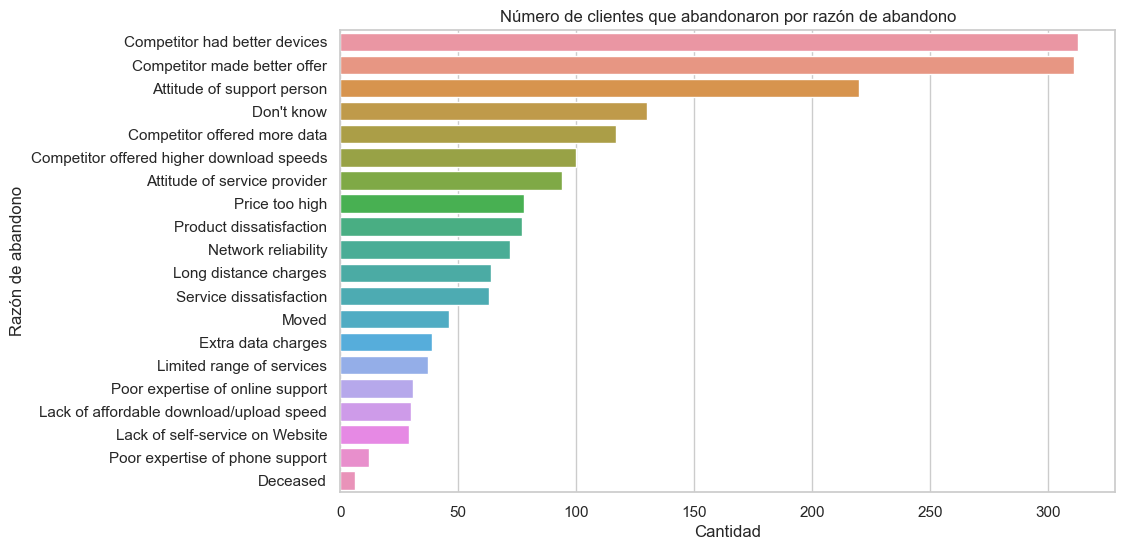

In [3]:
# Filtrar los datos donde el valor de 'Churn Value' sea 1
df_churned = df[df['Churn Value'] == 1]

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear la gráfica de barras para 'Churn Category'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_churned, y='Churn Category', order=df_churned['Churn Category'].value_counts().index)
plt.title('Número de clientes que abandonaron por categoría de abandono')
plt.xlabel('Cantidad')
plt.ylabel('Categoría de abandono')
plt.show()

# Crear la gráfica de barras para 'Churn Reason'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_churned, y='Churn Reason', order=df_churned['Churn Reason'].value_counts().index)
plt.title('Número de clientes que abandonaron por razón de abandono')
plt.xlabel('Cantidad')
plt.ylabel('Razón de abandono')
plt.show()

Se muestra el porcentaje de valores nulos. 
En este caso los campo son correctos ya que los campos con valores nulos (Churn Category,Churn Reason)  son por que representan las razones por la que cliente abandona el servicio

In [4]:
def null_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
print(null_summary(df))

                 Total    Percent
Churn Category    5174  73.463013
Churn Reason      5174  73.463013
Customer ID          0   0.000000
Count                0   0.000000
Quarter              0   0.000000
Customer Status      0   0.000000
Churn Label          0   0.000000
Churn Value          0   0.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Customer ID      7043 non-null   object
 1   Count            7043 non-null   int64 
 2   Quarter          7043 non-null   object
 3   Customer Status  7043 non-null   object
 4   Churn Label      7043 non-null   object
 5   Churn Value      7043 non-null   int64 
 6   Churn Category   1869 non-null   object
 7   Churn Reason     1869 non-null   object
dtypes: int64(2), object(6)
memory usage: 440.3+ KB


In [6]:
# Eliminar columnas específicas
columns_to_drop = ['Quarter', 'Customer Status','Count', 'Churn Label']
df = df.drop(columns=columns_to_drop)

df.head()

,Customer ID,Churn Value,Churn Category,Churn Reason
0,8779-QRDMV,1,Competitor,Competitor offered more data
1,7495-OOKFY,1,Competitor,Competitor made better offer
2,1658-BYGOY,1,Competitor,Competitor made better offer
3,4598-XLKNJ,1,Dissatisfaction,Limited range of services
4,4846-WHAFZ,1,Price,Extra data charges


In [7]:
# Seleccionar las columnas de tipo object para aplicar One-Hot Encoding
object_columns = df.select_dtypes(include=['object']).columns.tolist()
object_columns.remove('Customer ID')  # Excluir la columna 'Customer ID'

# Crear el codificador
encoder = OneHotEncoder(sparse=False)

# Ajustar y transformar los datos
encoded_data = encoder.fit_transform(df[object_columns])

# Obtener los nombres de las nuevas columnas después de aplicar One-Hot Encoding
encoded_columns = encoder.get_feature_names_out(input_features=object_columns)

# Convertir los datos codificados en un DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concatenar el DataFrame codificado con el DataFrame original
df_encoded = pd.concat([df.drop(object_columns, axis=1), encoded_df], axis=1)

# Verificar el DataFrame resultante
df_encoded.head()

,Customer ID,Churn Value,Churn Category_Attitude,Churn Category_Competitor,Churn Category_Dissatisfaction,Churn Category_Other,Churn Category_Price,Churn Category_nan,Churn Reason_Attitude of service provider,Churn Reason_Attitude of support person,...,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Churn Reason_nan
0,8779-QRDMV,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7495-OOKFY,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1658-BYGOY,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4598-XLKNJ,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4846-WHAFZ,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_Status = df_encoded

# Limpiamos Telco_customer_churn_demographics.csv

In [9]:
# Ruta del archivo ZIP
zip_file_path = "Churn.zip"
csv_filename = "Telco_customer_churn_demographics.csv"  # Nombre del archivo CSV dentro del ZIP

# Leer el archivo CSV directamente desde el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Mostrar las primeras filas para verificar que se ha leído correctamente
df.head()

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,M,78,No,Yes,No,No,0
1,7495-OOKFY,1,F,74,No,Yes,Yes,Yes,1
2,1658-BYGOY,1,M,71,No,Yes,No,Yes,3
3,4598-XLKNJ,1,F,78,No,Yes,Yes,Yes,1
4,4846-WHAFZ,1,F,80,No,Yes,Yes,Yes,1


In [10]:
df.replace({'Yes': 1, 'No': 0, 'M': 1, 'F': 0}, inplace=True)
df.head()

,Customer ID,Count,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,1,78,0,1,0,0,0
1,7495-OOKFY,1,0,74,0,1,1,1,1
2,1658-BYGOY,1,1,71,0,1,0,1,3
3,4598-XLKNJ,1,0,78,0,1,1,1,1
4,4846-WHAFZ,1,0,80,0,1,1,1,1


In [11]:
# Eliminar columnas específicas
columns_to_drop = ['Count']
df = df.drop(columns=columns_to_drop)

df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,78,0,1,0,0,0
1,7495-OOKFY,0,74,0,1,1,1,1
2,1658-BYGOY,1,71,0,1,0,1,3
3,4598-XLKNJ,0,78,0,1,1,1,1
4,4846-WHAFZ,0,80,0,1,1,1,1


In [12]:
def null_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
print(null_summary(df))

                      Total  Percent
Customer ID               0      0.0
Gender                    0      0.0
Age                       0      0.0
Under 30                  0      0.0
Senior Citizen            0      0.0
Married                   0      0.0
Dependents                0      0.0
Number of Dependents      0      0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer ID           7043 non-null   object
 1   Gender                7043 non-null   object
 2   Age                   7043 non-null   int64 
 3   Under 30              7043 non-null   int64 
 4   Senior Citizen        7043 non-null   int64 
 5   Married               7043 non-null   int64 
 6   Dependents            7043 non-null   int64 
 7   Number of Dependents  7043 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 440.3+ KB


In [14]:
df.replace({'Male': 1, 'Female': 0}, inplace=True)
df.head()

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents
0,8779-QRDMV,1,78,0,1,0,0,0
1,7495-OOKFY,0,74,0,1,1,1,1
2,1658-BYGOY,1,71,0,1,0,1,3
3,4598-XLKNJ,0,78,0,1,1,1,1
4,4846-WHAFZ,0,80,0,1,1,1,1


In [15]:
df_demographics = df

# Limpiamos Telco_customer_churn_location.csv

In [16]:
# Ruta del archivo ZIP
zip_file_path = "Churn.zip"
csv_filename = "Telco_customer_churn_location.csv"  # Nombre del archivo CSV dentro del ZIP

# Leer el archivo CSV directamente desde el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Mostrar las primeras filas para verificar que se ha leído correctamente
df.head()

,Customer ID,Count,Country,State,City,Zip Code,Latitude,Longitude
0,8779-QRDMV,1,United States,California,Los Angeles,90022,34.023810,-118.156582
1,7495-OOKFY,1,United States,California,Los Angeles,90063,34.044271,-118.185237
2,1658-BYGOY,1,United States,California,Los Angeles,90065,34.108833,-118.229715
3,4598-XLKNJ,1,United States,California,Inglewood,90303,33.936291,-118.332639
4,4846-WHAFZ,1,United States,California,Whittier,90602,33.972119,-118.020188


In [17]:
def null_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
print(null_summary(df))

             Total  Percent
Customer ID      0      0.0
Count            0      0.0
Country          0      0.0
State            0      0.0
City             0      0.0
Zip Code         0      0.0
Latitude         0      0.0
Longitude        0      0.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  7043 non-null   object 
 1   Count        7043 non-null   int64  
 2   Country      7043 non-null   object 
 3   State        7043 non-null   object 
 4   City         7043 non-null   object 
 5   Zip Code     7043 non-null   int64  
 6   Latitude     7043 non-null   float64
 7   Longitude    7043 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


In [19]:
# Eliminar columnas específicas
columns_to_drop = ['Count','Country', 'State']
df = df.drop(columns=columns_to_drop)
df.head()

,Customer ID,City,Zip Code,Latitude,Longitude
0,8779-QRDMV,Los Angeles,90022,34.023810,-118.156582
1,7495-OOKFY,Los Angeles,90063,34.044271,-118.185237
2,1658-BYGOY,Los Angeles,90065,34.108833,-118.229715
3,4598-XLKNJ,Inglewood,90303,33.936291,-118.332639
4,4846-WHAFZ,Whittier,90602,33.972119,-118.020188


In [20]:
# Seleccionar las columnas de tipo object para aplicar One-Hot Encoding 
object_columns = df.select_dtypes(include=['object']).columns.tolist()
object_columns.remove('Customer ID')  # Excluir la columna 'Customer ID'

# Crear el codificador
encoder = OneHotEncoder(sparse=False)

# Ajustar y transformar los datos
encoded_data = encoder.fit_transform(df[object_columns])

# Obtener los nombres de las nuevas columnas después de aplicar One-Hot Encoding
encoded_columns = encoder.get_feature_names_out(input_features=object_columns)

# Convertir los datos codificados en un DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concatenar el DataFrame codificado con el DataFrame original
df_encoded = pd.concat([df.drop(object_columns, axis=1), encoded_df], axis=1)

# Verificar el DataFrame resultante
df_encoded.head()

,Customer ID,Zip Code,Latitude,Longitude,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura Hills,City_Aguanga,...,City_Wrightwood,City_Yermo,City_Yorba Linda,City_Yorkville,City_Yountville,City_Yreka,City_Yuba City,City_Yucaipa,City_Yucca Valley,City_Zenia
0,8779-QRDMV,90022,34.023810,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7495-OOKFY,90063,34.044271,-118.185237,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1658-BYGOY,90065,34.108833,-118.229715,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4598-XLKNJ,90303,33.936291,-118.332639,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4846-WHAFZ,90602,33.972119,-118.020188,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_location = df_encoded  

**Limpiamos Telco_customer_churn_population.csv**

In [22]:
# Ruta del archivo ZIP
zip_file_path = "Churn.zip"
csv_filename = "Telco_customer_churn_population.csv"  # Nombre del archivo CSV dentro del ZIP

# Leer el archivo CSV directamente desde el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Mostrar las primeras filas para verificar que se ha leído correctamente
df.head()

,ID,Zip Code,Population
0,1,90001,54492
1,2,90002,44586
2,3,90003,58198
3,4,90004,67852
4,5,90005,43019


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          1671 non-null   int64
 1   Zip Code    1671 non-null   int64
 2   Population  1671 non-null   int64
dtypes: int64(3)
memory usage: 39.3 KB


In [24]:
def null_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
print(null_summary(df))

            Total  Percent
ID              0      0.0
Zip Code        0      0.0
Population      0      0.0


In [25]:
# Eliminar columnas específicas
columns_to_drop = ['ID']
df = df.drop(columns=columns_to_drop)
df.head()

,Zip Code,Population
0,90001,54492
1,90002,44586
2,90003,58198
3,90004,67852
4,90005,43019


In [26]:
df_population = df 

# Se une df_location con df_population para formar un solo DF realacionado por Zip Code**

In [27]:
# Unir los DataFrames en una sola tabla usando 'Zip Code'
df_merged = pd.merge(df_location, df_population, on='Zip Code')
# Mostrar el DataFrame resultante
df_merged.head()

,Customer ID,Zip Code,Latitude,Longitude,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura Hills,City_Aguanga,...,City_Yermo,City_Yorba Linda,City_Yorkville,City_Yountville,City_Yreka,City_Yuba City,City_Yucaipa,City_Yucca Valley,City_Zenia,Population
0,8779-QRDMV,90022,34.02381,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
1,4737-AQCPU,90022,34.02381,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
2,5043-TRZWM,90022,34.02381,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
3,8165-CBKXO,90022,34.02381,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
4,9979-RGMZT,90022,34.02381,-118.156582,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701


# Limpieza Telco_customer_churn_services.csv

In [28]:
# Ruta del archivo ZIP
zip_file_path = "Churn.zip"
csv_filename = "Telco_customer_churn_services.csv"  # Nombre del archivo CSV dentro del ZIP

# Leer el archivo CSV directamente desde el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as file:
        df = pd.read_csv(file)

# Mostrar las primeras filas para verificar que se ha leído correctamente
df.head()

,Customer ID,Count,Quarter,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,1,Q3,No,0,1,NaN,No,0.00,No,...,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,...,Yes,Month-to-Month,Yes,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,...,Yes,Month-to-Month,Yes,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


In [29]:
# Eliminar columnas específicas
columns_to_drop = ['Count', 'Count','Quarter',]
df = df.drop(columns=columns_to_drop)
df.replace({'Yes': 1, 'No': 0}, inplace=True)
df.head()

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,...,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,8779-QRDMV,0,0,1,NaN,0,0.00,0,1,DSL,...,0,Month-to-Month,1,Bank Withdrawal,39.65,39.65,0.00,20,0.00,59.65
1,7495-OOKFY,1,1,8,Offer E,1,48.85,1,1,Fiber Optic,...,1,Month-to-Month,1,Credit Card,80.65,633.30,0.00,0,390.80,1024.10
2,1658-BYGOY,0,0,18,Offer D,1,11.33,1,1,Fiber Optic,...,1,Month-to-Month,1,Bank Withdrawal,95.45,1752.55,45.61,0,203.94,1910.88
3,4598-XLKNJ,1,1,25,Offer C,1,19.76,0,1,Fiber Optic,...,1,Month-to-Month,1,Bank Withdrawal,98.50,2514.50,13.43,0,494.00,2995.07
4,4846-WHAFZ,1,1,37,Offer C,1,6.33,1,1,Fiber Optic,...,1,Month-to-Month,1,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   int64  
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Offer                              3166 non-null   object 
 5   Phone Service                      7043 non-null   int64  
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Multiple Lines                     7043 non-null   int64  
 8   Internet Service                   7043 non-null   int64  
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   int64

In [31]:
def null_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
print(null_summary(df))

                                   Total    Percent
Offer                               3877  55.047565
Internet Type                       1526  21.666903
Customer ID                            0   0.000000
Streaming TV                           0   0.000000
Total Long Distance Charges            0   0.000000
Total Extra Data Charges               0   0.000000
Total Refunds                          0   0.000000
Total Charges                          0   0.000000
Monthly Charge                         0   0.000000
Payment Method                         0   0.000000
Paperless Billing                      0   0.000000
Contract                               0   0.000000
Unlimited Data                         0   0.000000
Streaming Music                        0   0.000000
Streaming Movies                       0   0.000000
Premium Tech Support                   0   0.000000
Referred a Friend                      0   0.000000
Device Protection Plan                 0   0.000000
Online Backu

In [32]:
# Tratar los valores nulos
df.fillna(value={'Offer': 'No Offer', 'Internet Type': 'Unknown'}, inplace=True)

# Seleccionar columnas categóricas para One-Hot Encoding
categorical_columns = ['Offer', 'Internet Type', 'Contract', 'Payment Method']

# Aplicar One-Hot Encoding a las columnas categóricas
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' para evitar la multicolinealidad
encoded_features = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenar el DataFrame codificado con el DataFrame original y eliminar las columnas categóricas
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Verificar el nuevo DataFrame
df_encoded

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,...,Offer_Offer C,Offer_Offer D,Offer_Offer E,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_Unknown,Contract_One Year,Contract_Two Year,Payment Method_Credit Card,Payment Method_Mailed Check
0,8779-QRDMV,0,0,1,0,0.00,0,1,8,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7495-OOKFY,1,1,8,1,48.85,1,1,17,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1658-BYGOY,0,0,18,1,11.33,1,1,52,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4598-XLKNJ,1,1,25,1,19.76,0,1,12,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4846-WHAFZ,1,1,37,1,6.33,1,1,14,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9388-ZEYVT,0,0,43,0,0.00,0,1,11,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
7039,6898-RBTLU,1,9,49,1,16.60,1,1,14,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7040,5681-LLOEI,1,11,43,1,42.22,1,1,25,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7041,1036-GUDCL,1,1,60,1,39.76,0,1,76,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
df_services = df_encoded

In [34]:
df_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   int64  
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Phone Service                      7043 non-null   int64  
 5   Avg Monthly Long Distance Charges  7043 non-null   float64
 6   Multiple Lines                     7043 non-null   int64  
 7   Internet Service                   7043 non-null   int64  
 8   Avg Monthly GB Download            7043 non-null   int64  
 9   Online Security                    7043 non-null   int64  
 10  Online Backup                      7043 non-null   int64  
 11  Device Protection Plan             7043 non-null   int64

In [35]:
#  DataFrames df_services, df_demographics, df_Status y df_merged ya están definidos

# Unificar df_services con df_demographics
df_combined = df_services.merge(df_demographics, on="Customer ID", how="left")

# Unificar df_combined con df_Status
df_combined = df_combined.merge(df_Status, on="Customer ID", how="left")

# Unificar df_combined con df_merged
df_combined = df_combined.merge(df_merged, on="Customer ID", how="left")

# Verificar el DataFrame unificado
df_combined.head()


,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,...,City_Yermo,City_Yorba Linda,City_Yorkville,City_Yountville,City_Yreka,City_Yuba City,City_Yucaipa,City_Yucca Valley,City_Zenia,Population
0,8779-QRDMV,0,0,1,0,0.00,0,1,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
1,7495-OOKFY,1,1,8,1,48.85,1,1,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55668
2,1658-BYGOY,0,0,18,1,11.33,1,1,52,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47534
3,4598-XLKNJ,1,1,25,1,19.76,0,1,12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27778
4,4846-WHAFZ,1,1,37,1,6.33,1,1,14,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26265


In [36]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 1181 entries, Customer ID to Population
dtypes: float64(1153), int64(27), object(1)
memory usage: 63.5+ MB


In [37]:
# Eliminar duplicados basados en la columna 'Customer ID'
df_combined = df_combined.drop_duplicates(subset='Customer ID')


In [38]:
df_churn = df_combined

# DF churn consolidado

In [39]:
df_churn

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,...,City_Yermo,City_Yorba Linda,City_Yorkville,City_Yountville,City_Yreka,City_Yuba City,City_Yucaipa,City_Yucca Valley,City_Zenia,Population
0,8779-QRDMV,0,0,1,0,0.00,0,1,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
1,7495-OOKFY,1,1,8,1,48.85,1,1,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55668
2,1658-BYGOY,0,0,18,1,11.33,1,1,52,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47534
3,4598-XLKNJ,1,1,25,1,19.76,0,1,12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27778
4,4846-WHAFZ,1,1,37,1,6.33,1,1,14,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9388-ZEYVT,0,0,43,0,0.00,0,1,11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47758
7039,6898-RBTLU,1,9,49,1,16.60,1,1,14,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26265
7040,5681-LLOEI,1,11,43,1,42.22,1,1,25,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27614
7041,1036-GUDCL,1,1,60,1,39.76,0,1,76,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14814


# Limpieza 2da Fuente de Datos Gubernamental CAINC1.ZIP

In [40]:

# Descomprimir el archivo ZIP y cargar el archivo CSV hasta el registro 178
with zipfile.ZipFile('CAINC1.zip', 'r') as zip_ref:
    zip_ref.extractall('CAINC1')

# Cargar el archivo CSV completo en un DataFrame, limitando a 178 registros
df = pd.read_csv('CAINC1/CAINC1_CA_1969_2022.csv', nrows=178)

# Eliminar las comillas de la columna GeoFIPS
df['GeoFIPS'] = df['GeoFIPS'].str.replace('"', '')

# Eliminar los tres primeros números de la columna GeoFIPS y convertir a string
df['GeoFIPS'] = df['GeoFIPS'].str[3:]


# Continuar con el resto del procesamiento

# Filtrar las columnas necesarias
df_filtered = df[['GeoFIPS', 'Description', '2022']]

# Eliminar duplicados
df_filtered.drop_duplicates(inplace=True)

# Pivotar la tabla para tener Description como header y GeoFIPS como índice
df_pivoted = df_filtered.pivot(index='GeoFIPS', columns='Description', values='2022')

# Reiniciar el índice
df_pivoted.reset_index(inplace=True)

# Eliminar el nombre de las columnas del índice
df_pivoted.columns.name = None

# Eliminar la columna con encabezado NaN
df_pivoted = df_pivoted.loc[:, ~df_pivoted.columns.isna()]

# Eliminar filas con NaN en cualquier columna
df_pivoted.dropna(how='all', inplace=True)

# Mostrar el DataFrame final
df_CAINC1 = df_pivoted
df_CAINC1.head()


,GeoFIPS,Per capita personal income (dollars) 2/,Personal income (thousands of dollars),Population (persons) 1/
0,000,77036.0,3.006647e+09,39029342.0
1,001,97754.0,1.592411e+08,1628997.0
2,003,67551.0,8.038600e+04,1190.0
3,005,48463.0,2.006939e+06,41412.0
4,007,54974.0,1.139634e+07,207303.0


In [41]:
# Eliminar filas con valores nulos
df_CAINC1.dropna(inplace=True)

# Limpieza 2da Fuente de Datos Gubernamental CAINC30.ZIP

In [42]:
# Descomprimir el archivo ZIP y cargar el archivo CSV
with zipfile.ZipFile('CAINC30.zip', 'r') as zip_ref:
    zip_ref.extractall('CAINC30')

# Cargar el archivo CSV completo en un DataFrame
df = pd.read_csv('CAINC30/CAINC30_CA_1969_2022.csv')

# Eliminar las comillas de la columna GeoFIPS
df['GeoFIPS'] = df['GeoFIPS'].str.replace('"', '')

# Eliminar los tres primeros números de la columna GeoFIPS y convertir a string
df['GeoFIPS'] = df['GeoFIPS'].str[3:]

# Filtrar las columnas necesarias
df_filtered = df[['GeoFIPS', 'Description', '2022']]

# Eliminar duplicados
df_filtered.drop_duplicates(inplace=True)

# Pivotar la tabla para tener Description como header y GeoFIPS como índice
df_pivoted = df_filtered.pivot(index='GeoFIPS', columns='Description', values='2022')

# Reiniciar el índice
df_pivoted.reset_index(inplace=True)

# Eliminar el nombre de las columnas del índice
df_pivoted.columns.name = None

# Eliminar la columna con encabezado NaN
df_pivoted = df_pivoted.loc[:, ~df_pivoted.columns.isna()]

# Eliminar filas con NaN en cualquier columna
df_pivoted.dropna(how='all', inplace=True)

# Eliminar el registro 0
df_CAINC30 = df_pivoted.iloc[1:]

# Eliminar filas con valores nulos
df_CAINC30.dropna(inplace=True)

# Mostrar el DataFrame final
df_CAINC30.head()


,GeoFIPS,Employer contributions for employee pension and insurance funds 5/,Employer contributions for government social insurance,Farm proprietors' income,Nonfarm proprietors' income,Farm proprietors employment 6/,Income maintenance benefits 1/,Nonfarm proprietors employment,Per capita income maintenance benefits 4/,Per capita retirement and other 4/,...,Per capita net earnings 4/,Per capita personal current transfer receipts 4/,Per capita personal income 4/,Personal current transfer receipts,Population (persons) 3/,Proprietors employment,Wage and salary employment,Average earnings per job (dollars),Personal income (thousands of dollars),Total employment (number of jobs)
1,000,222888068.0,100153037.0,7699661.0,230460247.0,55474.0,67953536.0,6431184.0,1741.0,10527.0,...,49578.0,12385.0,77036.0,483364725.0,39029342.0,6486658.0,18814316.0,85710.0,3.006647e+09,25300974.0
2,001,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,255691.0,1487.0,10485.0,...,69489.0,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,1.592411e+08,1100959.0
3,003,9036.0,3687.0,0.0,1258.0,0.0,1745.0,177.0,1466.0,16918.0,...,33389.0,18512.0,67551.0,22029.0,1190.0,177.0,983.0,62828.0,8.038600e+04,1160.0
4,005,175290.0,43587.0,-951.0,131906.0,337.0,44706.0,5234.0,1080.0,13224.0,...,24780.0,14388.0,48463.0,595847.0,41412.0,5571.0,12805.0,58025.0,2.006939e+06,18376.0
5,007,906838.0,319461.0,51242.0,923526.0,1493.0,424778.0,25089.0,2049.0,13454.0,...,30028.0,15613.0,54974.0,3236562.0,207303.0,26582.0,85322.0,60923.0,1.139634e+07,111904.0


In [43]:
df_CAINC30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 1 to 59
Data columns (total 32 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   GeoFIPS                                                                59 non-null     object 
 1      Employer contributions for employee pension and insurance funds 5/  59 non-null     float64
 2      Employer contributions for government social insurance              59 non-null     float64
 3      Farm proprietors' income                                            59 non-null     float64
 4      Nonfarm proprietors' income                                         59 non-null     float64
 5     Farm proprietors employment 6/                                       59 non-null     float64
 6     Income maintenance benefits 1/                                       59 non-null     float64
 7

**Unimos los 2 df de CAINC por el campo GeoName**

In [44]:
# Unir los DataFrames por la columna 'GeoName'
df_combined = pd.merge(df_CAINC1, df_CAINC30, on='GeoFIPS')

# Identificar columnas duplicadas (sin contar 'GeoFIPS')
duplicate_columns = [col for col in df_combined.columns if col.endswith('_x') or col.endswith('_y')]

# Eliminar las columnas duplicadas
df_combined.drop(columns=duplicate_columns, inplace=True)

# Unir los DataFrames por la columna 'GeoFIPS'
df_combined = pd.merge(df_CAINC1, df_CAINC30, on='GeoFIPS')

# Eliminar columnas duplicadas, manteniendo solo la primera aparición
df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]


In [45]:
df_CAINC = df_combined
df_CAINC.head()

,GeoFIPS,Per capita personal income (dollars) 2/,Personal income (thousands of dollars) _x,Population (persons) 1/,Employer contributions for employee pension and insurance funds 5/,Employer contributions for government social insurance,Farm proprietors' income,Nonfarm proprietors' income,Farm proprietors employment 6/,Income maintenance benefits 1/,...,Per capita net earnings 4/,Per capita personal current transfer receipts 4/,Per capita personal income 4/,Personal current transfer receipts,Population (persons) 3/,Proprietors employment,Wage and salary employment,Average earnings per job (dollars),Personal income (thousands of dollars) _y,Total employment (number of jobs)
0,000,77036.0,3.006647e+09,39029342.0,222888068.0,100153037.0,7699661.0,230460247.0,55474.0,67953536.0,...,49578.0,12385.0,77036.0,483364725.0,39029342.0,6486658.0,18814316.0,85710.0,3.006647e+09,25300974.0
1,001,97754.0,1.592411e+08,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,69489.0,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,1.592411e+08,1100959.0
2,003,67551.0,8.038600e+04,1190.0,9036.0,3687.0,0.0,1258.0,0.0,1745.0,...,33389.0,18512.0,67551.0,22029.0,1190.0,177.0,983.0,62828.0,8.038600e+04,1160.0
3,005,48463.0,2.006939e+06,41412.0,175290.0,43587.0,-951.0,131906.0,337.0,44706.0,...,24780.0,14388.0,48463.0,595847.0,41412.0,5571.0,12805.0,58025.0,2.006939e+06,18376.0
4,007,54974.0,1.139634e+07,207303.0,906838.0,319461.0,51242.0,923526.0,1493.0,424778.0,...,30028.0,15613.0,54974.0,3236562.0,207303.0,26582.0,85322.0,60923.0,1.139634e+07,111904.0


In [46]:
# Cargar Telco_customer_churn_location_with_city_county_code.csv y eliminar filas con valores nulos
telco_df = pd.read_csv("Telco_customer_churn_location_with_city_county_code.csv").dropna()

# Convertir County_Code a entero y luego a string
telco_df['County_Code'] = telco_df['County_Code'].astype(int).astype(str)

# Agregar '0' al inicio si tiene 1 o 2 dígitos
telco_df['County_Code'] = telco_df['County_Code'].apply(lambda x: x.zfill(3))

# Fusionar los dataframes usando GeoFIPS y County_Code
merged_df = pd.merge(df_CAINC, telco_df, left_on='GeoFIPS', right_on='County_Code', how='left')

# Eliminar columnas duplicadas
merged_df.drop(columns=['County_Code'], inplace=True)

# Eliminar filas donde GeoFIPS es igual a "000"
merged_df = merged_df[merged_df['GeoFIPS'] != '000']

# Eliminar campos adicionales
merged_df.drop(columns=['Customer ID', 'Count', 'Country', 'State', 'City', 'Latitude', 'Longitude'], inplace=True)

# Eliminar filas con valores nulos
merged_df.dropna(inplace=True)
merged_df.info()

# Mostrar el DataFrame fusionado sin duplicados
merged_df.head(500)


<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 1 to 7039
Data columns (total 36 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   GeoFIPS                                                                7039 non-null   object 
 1   Per capita personal income (dollars) 2/                                7039 non-null   float64
 2   Personal income (thousands of dollars) _x                              7039 non-null   float64
 3   Population (persons) 1/                                                7039 non-null   float64
 4      Employer contributions for employee pension and insurance funds 5/  7039 non-null   float64
 5      Employer contributions for government social insurance              7039 non-null   float64
 6      Farm proprietors' income                                            7039 non-null   float6

,GeoFIPS,Per capita personal income (dollars) 2/,Personal income (thousands of dollars) _x,Population (persons) 1/,Employer contributions for employee pension and insurance funds 5/,Employer contributions for government social insurance,Farm proprietors' income,Nonfarm proprietors' income,Farm proprietors employment 6/,Income maintenance benefits 1/,...,Per capita personal current transfer receipts 4/,Per capita personal income 4/,Personal current transfer receipts,Population (persons) 3/,Proprietors employment,Wage and salary employment,Average earnings per job (dollars),Personal income (thousands of dollars) _y,Total employment (number of jobs),Zip Code
1,001,97754.0,159241119.0,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,159241119.0,1100959.0,94539.0
2,001,97754.0,159241119.0,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,159241119.0,1100959.0,94550.0
3,001,97754.0,159241119.0,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,159241119.0,1100959.0,94566.0
4,001,97754.0,159241119.0,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,159241119.0,1100959.0,94588.0
5,001,97754.0,159241119.0,1628997.0,10955073.0,5225511.0,31062.0,12633213.0,316.0,2421858.0,...,12066.0,97754.0,19655203.0,1628997.0,256007.0,844952.0,99419.0,159241119.0,1100959.0,94704.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,013,95047.0,109965993.0,1156966.0,4820484.0,2228673.0,23020.0,7567337.0,434.0,1349628.0,...,11667.0,95047.0,13498744.0,1156966.0,198886.0,397089.0,80676.0,109965993.0,595975.0,94506.0
497,013,95047.0,109965993.0,1156966.0,4820484.0,2228673.0,23020.0,7567337.0,434.0,1349628.0,...,11667.0,95047.0,13498744.0,1156966.0,198886.0,397089.0,80676.0,109965993.0,595975.0,94507.0
498,013,95047.0,109965993.0,1156966.0,4820484.0,2228673.0,23020.0,7567337.0,434.0,1349628.0,...,11667.0,95047.0,13498744.0,1156966.0,198886.0,397089.0,80676.0,109965993.0,595975.0,94509.0
499,013,95047.0,109965993.0,1156966.0,4820484.0,2228673.0,23020.0,7567337.0,434.0,1349628.0,...,11667.0,95047.0,13498744.0,1156966.0,198886.0,397089.0,80676.0,109965993.0,595975.0,94511.0


In [47]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 1 to 7039
Data columns (total 36 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   GeoFIPS                                                                7039 non-null   object 
 1   Per capita personal income (dollars) 2/                                7039 non-null   float64
 2   Personal income (thousands of dollars) _x                              7039 non-null   float64
 3   Population (persons) 1/                                                7039 non-null   float64
 4      Employer contributions for employee pension and insurance funds 5/  7039 non-null   float64
 5      Employer contributions for government social insurance              7039 non-null   float64
 6      Farm proprietors' income                                            7039 non-null   float6

In [48]:
num_filas, num_columnas = merged_df.shape
print("Número de filas:", num_filas)
print("Número de columnas:", num_columnas)


Número de filas: 7039
Número de columnas: 36


In [49]:
df_CAINC = merged_df

In [50]:

num_filas, num_columnas = df_churn.shape
print("Número de filas:", num_filas)
print("Número de columnas:", num_columnas)
df_churn.head()

Número de filas: 7043
Número de columnas: 1181


,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,...,City_Yermo,City_Yorba Linda,City_Yorkville,City_Yountville,City_Yreka,City_Yuba City,City_Yucaipa,City_Yucca Valley,City_Zenia,Population
0,8779-QRDMV,0,0,1,0,0.00,0,1,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68701
1,7495-OOKFY,1,1,8,1,48.85,1,1,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55668
2,1658-BYGOY,0,0,18,1,11.33,1,1,52,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47534
3,4598-XLKNJ,1,1,25,1,19.76,0,1,12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27778
4,4846-WHAFZ,1,1,37,1,6.33,1,1,14,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26265


### Eliminamos columnas City, se utilizará como referencia el ZIPCode o coordenadas geograficas.

In [51]:

# Filtrar columnas que incluyen la palabra "City_"
df_churn = df_churn.loc[:, ~df_churn.columns.str.contains('City_')]

# Verifica el resultado para asegurarte de que las columnas fueron eliminadas
print(df_churn.head())


  Customer ID  Referred a Friend  Number of Referrals  Tenure in Months  \
0  8779-QRDMV                  0                    0                 1   
1  7495-OOKFY                  1                    1                 8   
2  1658-BYGOY                  0                    0                18   
3  4598-XLKNJ                  1                    1                25   
4  4846-WHAFZ                  1                    1                37   

   Phone Service  Avg Monthly Long Distance Charges  Multiple Lines  \
0              0                               0.00               0   
1              1                              48.85               1   
2              1                              11.33               1   
3              1                              19.76               0   
4              1                               6.33               1   

   Internet Service  Avg Monthly GB Download  Online Security  ...  \
0                 1                        8        

In [52]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 75 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Customer ID                                             7043 non-null   object 
 1   Referred a Friend                                       7043 non-null   int64  
 2   Number of Referrals                                     7043 non-null   int64  
 3   Tenure in Months                                        7043 non-null   int64  
 4   Phone Service                                           7043 non-null   int64  
 5   Avg Monthly Long Distance Charges                       7043 non-null   float64
 6   Multiple Lines                                          7043 non-null   int64  
 7   Internet Service                                        7043 non-null   int64  
 8   Avg Monthly GB Download               

In [53]:

# Convertir las columnas 'Zip Code' a enteros
df_churn['Zip Code'] = pd.to_numeric(df_churn['Zip Code'], errors='coerce').astype('Int64')
df_CAINC['Zip Code'] = pd.to_numeric(df_CAINC['Zip Code'], errors='coerce').astype('Int64')

# Realizar una unión de tipo 'left' para mantener todos los registros de df_churn
merged_df = pd.merge(df_churn, df_CAINC, on='Zip Code', how='left')


In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38075 entries, 0 to 38074
Columns: 110 entries, Customer ID to Total employment (number of jobs) 
dtypes: Int64(1), float64(81), int64(26), object(2)
memory usage: 32.0+ MB


In [55]:
# Eliminar filas duplicadas
merged_df = merged_df.drop_duplicates()

In [56]:
# Eliminar columnas duplicadas
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

In [57]:
# Eliminar registros con valores nulos
merged_df_clean = merged_df.dropna()

In [58]:
num_filas, num_columnas = merged_df.shape
print("Número de filas:", num_filas)
print("Número de columnas:", num_columnas)
merged_df.head()

Número de filas: 7043
Número de columnas: 110


,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,...,Per capita net earnings 4/,Per capita personal current transfer receipts 4/,Per capita personal income 4/,Personal current transfer receipts,Population (persons) 3/,Proprietors employment,Wage and salary employment,Average earnings per job (dollars),Personal income (thousands of dollars) _y,Total employment (number of jobs)
0,8779-QRDMV,0,0,1,0,0.00,0,1,8,0,...,45090.0,14353.0,74142.0,139526360.0,9721138.0,1962132.0,4843059.0,77731.0,720740528.0,6805191.0
5,7495-OOKFY,1,1,8,1,48.85,1,1,17,0,...,45090.0,14353.0,74142.0,139526360.0,9721138.0,1962132.0,4843059.0,77731.0,720740528.0,6805191.0
10,1658-BYGOY,0,0,18,1,11.33,1,1,52,0,...,45090.0,14353.0,74142.0,139526360.0,9721138.0,1962132.0,4843059.0,77731.0,720740528.0,6805191.0
15,4598-XLKNJ,1,1,25,1,19.76,0,1,12,0,...,45090.0,14353.0,74142.0,139526360.0,9721138.0,1962132.0,4843059.0,77731.0,720740528.0,6805191.0
20,4846-WHAFZ,1,1,37,1,6.33,1,1,14,0,...,45090.0,14353.0,74142.0,139526360.0,9721138.0,1962132.0,4843059.0,77731.0,720740528.0,6805191.0


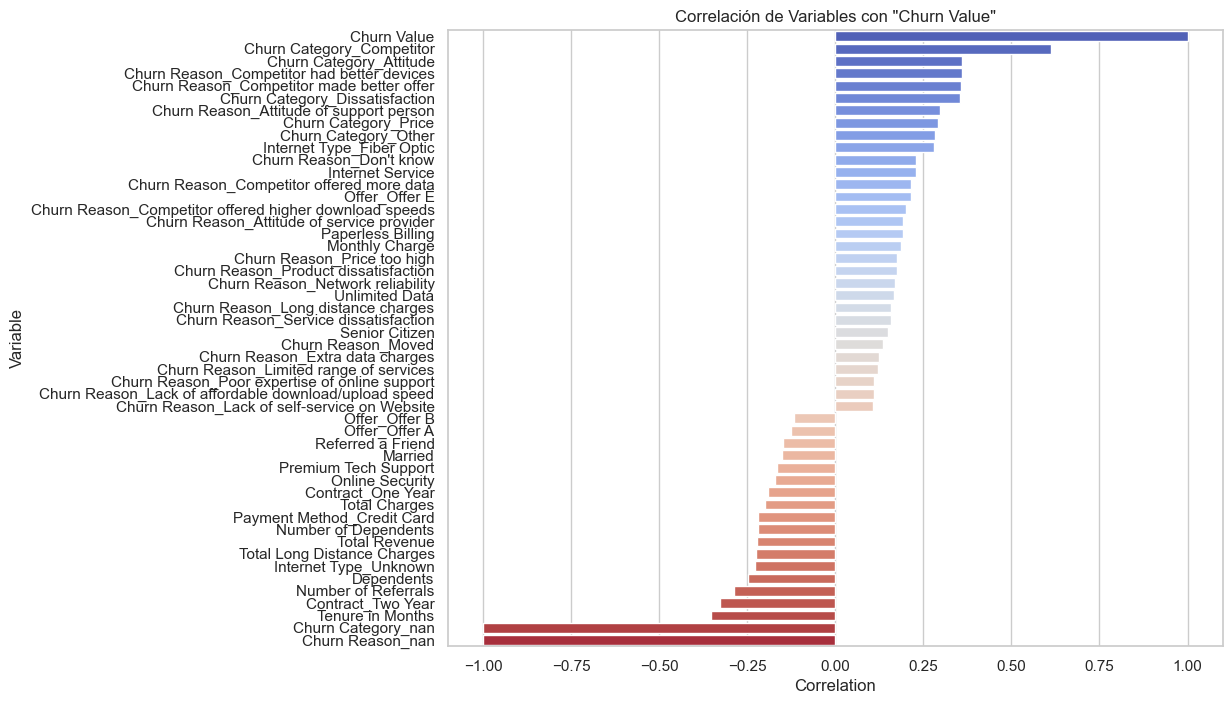

In [59]:

# Eliminar la columna "Customer ID"
merged_df = merged_df.drop(columns=['Customer ID'])

# Calcular la matriz de correlación completa
corr_matrix = merged_df.corr()

# Extraer la fila correspondiente a "Churn Value"
churn_corr = corr_matrix["Churn Value"].sort_values(ascending=False)

merged_df.dropna(inplace=True)

# Crear un DataFrame de las correlaciones
churn_corr_df = pd.DataFrame(churn_corr).reset_index()
churn_corr_df.columns = ['Variable', 'Correlation']

# Filtrar las correlaciones más relevantes (por ejemplo, las que tienen un valor absoluto mayor a 0.1)
relevant_corr = churn_corr_df[churn_corr_df['Correlation'].abs() > 0.1]

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear un gráfico de barras de las correlaciones más relevantes
sns.barplot(x='Correlation', y='Variable', data=relevant_corr, palette='coolwarm')

# Título del gráfico
plt.title('Correlación de Variables con "Churn Value"')

# Mostrar el gráfico
plt.show()


In [60]:

# Contar los valores nulos en cada columna
null_counts = merged_df.isnull().sum()

# Mostrar los resultados
print(null_counts)


Referred a Friend                            0
Number of Referrals                          0
Tenure in Months                             0
Phone Service                                0
Avg Monthly Long Distance Charges            0
                                            ..
 Proprietors employment                      0
 Wage and salary employment                  0
Average earnings per job (dollars)           0
Personal income (thousands of dollars) _y    0
Total employment (number of jobs)            0
Length: 109, dtype: int64


In [61]:
print(merged_df)

       Referred a Friend  Number of Referrals  Tenure in Months  \
0                      0                    0                 1   
5                      1                    1                 8   
10                     0                    0                18   
15                     1                    1                25   
20                     1                    1                37   
...                  ...                  ...               ...   
38050                  0                    0                43   
38055                  1                    9                49   
38060                  1                   11                43   
38065                  1                    1                60   
38070                  1                    1                44   

       Phone Service  Avg Monthly Long Distance Charges  Multiple Lines  \
0                  0                               0.00               0   
5                  1                         

In [62]:
import pandas as pd

# Suponiendo que ya tienes tu DataFrame merged_df listo para ser guardado

# Guardar el DataFrame como CSV en la raíz del proyecto
merged_df.to_csv('merged_df_prueba.csv', index=False)

print("Archivo CSV guardado exitosamente como 'merged_df_prueba.csv'")


Archivo CSV guardado exitosamente como 'merged_df_prueba.csv'


## Se elimina las columnas que tienen una correlacion mayor al 95% entre las variables del DataFrame evitando la multicolinealidad.

In [63]:
if 'Customer ID' in merged_df_clean.columns:
    merged_df_clean.drop(columns=['Customer ID'], inplace=True)

# Calcular la matriz de correlación
corr_matrix = merged_df_clean.corr().abs()

# Seleccionar el triángulo superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar los índices de las columnas con una correlación mayor a 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Eliminar las columnas altamente correlacionadas
merged_df_reduced = merged_df_clean.drop(columns=to_drop)

# Mostrar el DataFrame reducido
print("DataFrame reducido:")
print(merged_df_reduced)

# Mostrar las columnas eliminadas
print("\nColumnas eliminadas debido a alta correlación:")
to_drop


DataFrame reducido:
       Referred a Friend  Number of Referrals  Tenure in Months  \
0                      0                    0                 1   
5                      1                    1                 8   
10                     0                    0                18   
15                     1                    1                25   
20                     1                    1                37   
...                  ...                  ...               ...   
38050                  0                    0                43   
38055                  1                    9                49   
38060                  1                   11                43   
38065                  1                    1                60   
38070                  1                    1                44   

       Phone Service  Avg Monthly Long Distance Charges  Multiple Lines  \
0                  0                               0.00               0   
5                  1     

['Total Revenue',
 'Internet Type_Unknown',
 'Churn Category_nan',
 'Churn Reason_nan',
 'Population (persons) 1/',
 '   Employer contributions for employee pension and insurance funds 5/',
 '   Employer contributions for government social insurance ',
 "   Nonfarm proprietors' income ",
 '  Income maintenance benefits 1/',
 '  Nonfarm proprietors employment ',
 "  Proprietors' income ",
 '  Retirement and other ',
 '  Supplements to wages and salaries ',
 '  Unemployment insurance compensation ',
 '  Wages and salaries ',
 ' Dividends, interest, and rent 2/',
 ' Earnings by place of work ',
 ' Net earnings by place of residence ',
 ' Per capita dividends, interest, and rent 4/',
 ' Per capita net earnings 4/',
 ' Per capita personal current transfer receipts 4/',
 ' Per capita personal income 4/',
 ' Personal current transfer receipts ',
 ' Population (persons) 3/',
 ' Proprietors employment ',
 ' Wage and salary employment ',
 'Average earnings per job (dollars) ',
 'Personal income 

In [64]:
merged_df_reduced

,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,Online Backup,...,GeoFIPS,Per capita personal income (dollars) 2/,Personal income (thousands of dollars) _x,Farm proprietors' income,Farm proprietors employment 6/,Per capita income maintenance benefits 4/,Per capita retirement and other 4/,Per capita unemployment insurance compensation 4/,Average nonfarm proprietors' income,Average wages and salaries
0,0,0,1,0,0.00,0,1,8,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
5,1,1,8,1,48.85,1,1,17,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
10,0,0,18,1,11.33,1,1,52,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
15,1,1,25,1,19.76,0,1,12,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
20,1,1,37,1,6.33,1,1,14,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38050,0,0,43,0,0.00,0,1,11,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38055,1,9,49,1,16.60,1,1,14,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38060,1,11,43,1,42.22,1,1,25,1,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38065,1,1,60,1,39.76,0,1,76,1,1,...,111,76375.0,63589878.0,258229.0,1494.0,1131.0,10188.0,103.0,36249.0,68239.0


In [65]:
df = merged_df_reduced
merged_df_reduced

,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,Online Backup,...,GeoFIPS,Per capita personal income (dollars) 2/,Personal income (thousands of dollars) _x,Farm proprietors' income,Farm proprietors employment 6/,Per capita income maintenance benefits 4/,Per capita retirement and other 4/,Per capita unemployment insurance compensation 4/,Average nonfarm proprietors' income,Average wages and salaries
0,0,0,1,0,0.00,0,1,8,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
5,1,1,8,1,48.85,1,1,17,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
10,0,0,18,1,11.33,1,1,52,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
15,1,1,25,1,19.76,0,1,12,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
20,1,1,37,1,6.33,1,1,14,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38050,0,0,43,0,0.00,0,1,11,0,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38055,1,9,49,1,16.60,1,1,14,0,1,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38060,1,11,43,1,42.22,1,1,25,1,0,...,037,74142.0,720740528.0,32484.0,853.0,2397.0,11815.0,141.0,30547.0,80151.0
38065,1,1,60,1,39.76,0,1,76,1,1,...,111,76375.0,63589878.0,258229.0,1494.0,1131.0,10188.0,103.0,36249.0,68239.0


In [66]:
# Eliminar espacios en blanco de los encabezados de las columnas
df.columns = df.columns.str.strip()

In [67]:
# Renombrar las columnas especificadas
df = df.rename(columns={
    'Per capita personal income (dollars) 2/': 'Per capita personal income (dollars)',
    'Personal income (thousands of dollars) _x': 'Personal income (thousands of dollars)',
    'Farm proprietors employment 6/': 'Farm proprietors employment',
    'Per capita income maintenance benefits 4/': 'Per capita income maintenance benefits',
    'Per capita retirement and other 4/': 'Per capita retirement and other',
    'Per capita unemployment insurance compensation 4/': 'Per capita unemployment insurance compensation'
})

# Verificar que se hayan renombrado correctamente
print(df.columns)

Index(['Referred a Friend', 'Number of Referrals', 'Tenure in Months',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Avg Monthly GB Download', 'Online Security',
       'Online Backup', 'Device Protection Plan', 'Premium Tech Support',
       'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data',
       'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer D',
       'Offer_Offer E', 'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Contract_One Year', 'Contract_Two Year', 'Payment Method_Credit Card',
       'Payment Method_Mailed Check', 'Gender', 'Age', 'Under 30',
       'Senior Citizen', 'Married', 'Dependents', 'Number of Dependents',
       'Churn Value', 'Churn Category_Attitude', 'Churn Category_Competitor',
       'Churn Category_Dissati

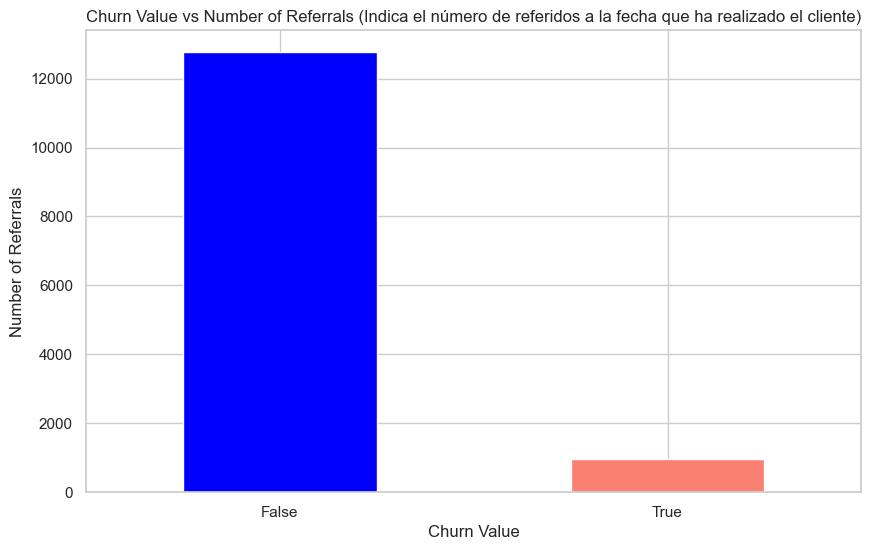

In [68]:
# Graficar
plt.figure(figsize=(10, 6))
df.groupby('Churn Value')['Number of Referrals'].sum().plot(kind='bar', color=['blue', 'salmon'])
plt.title('Churn Value vs Number of Referrals (Indica el número de referidos a la fecha que ha realizado el cliente)')
plt.xlabel('Churn Value')
plt.ylabel('Number of Referrals')
plt.xticks([1, 0], ['True', 'False'], rotation=0)
plt.show()

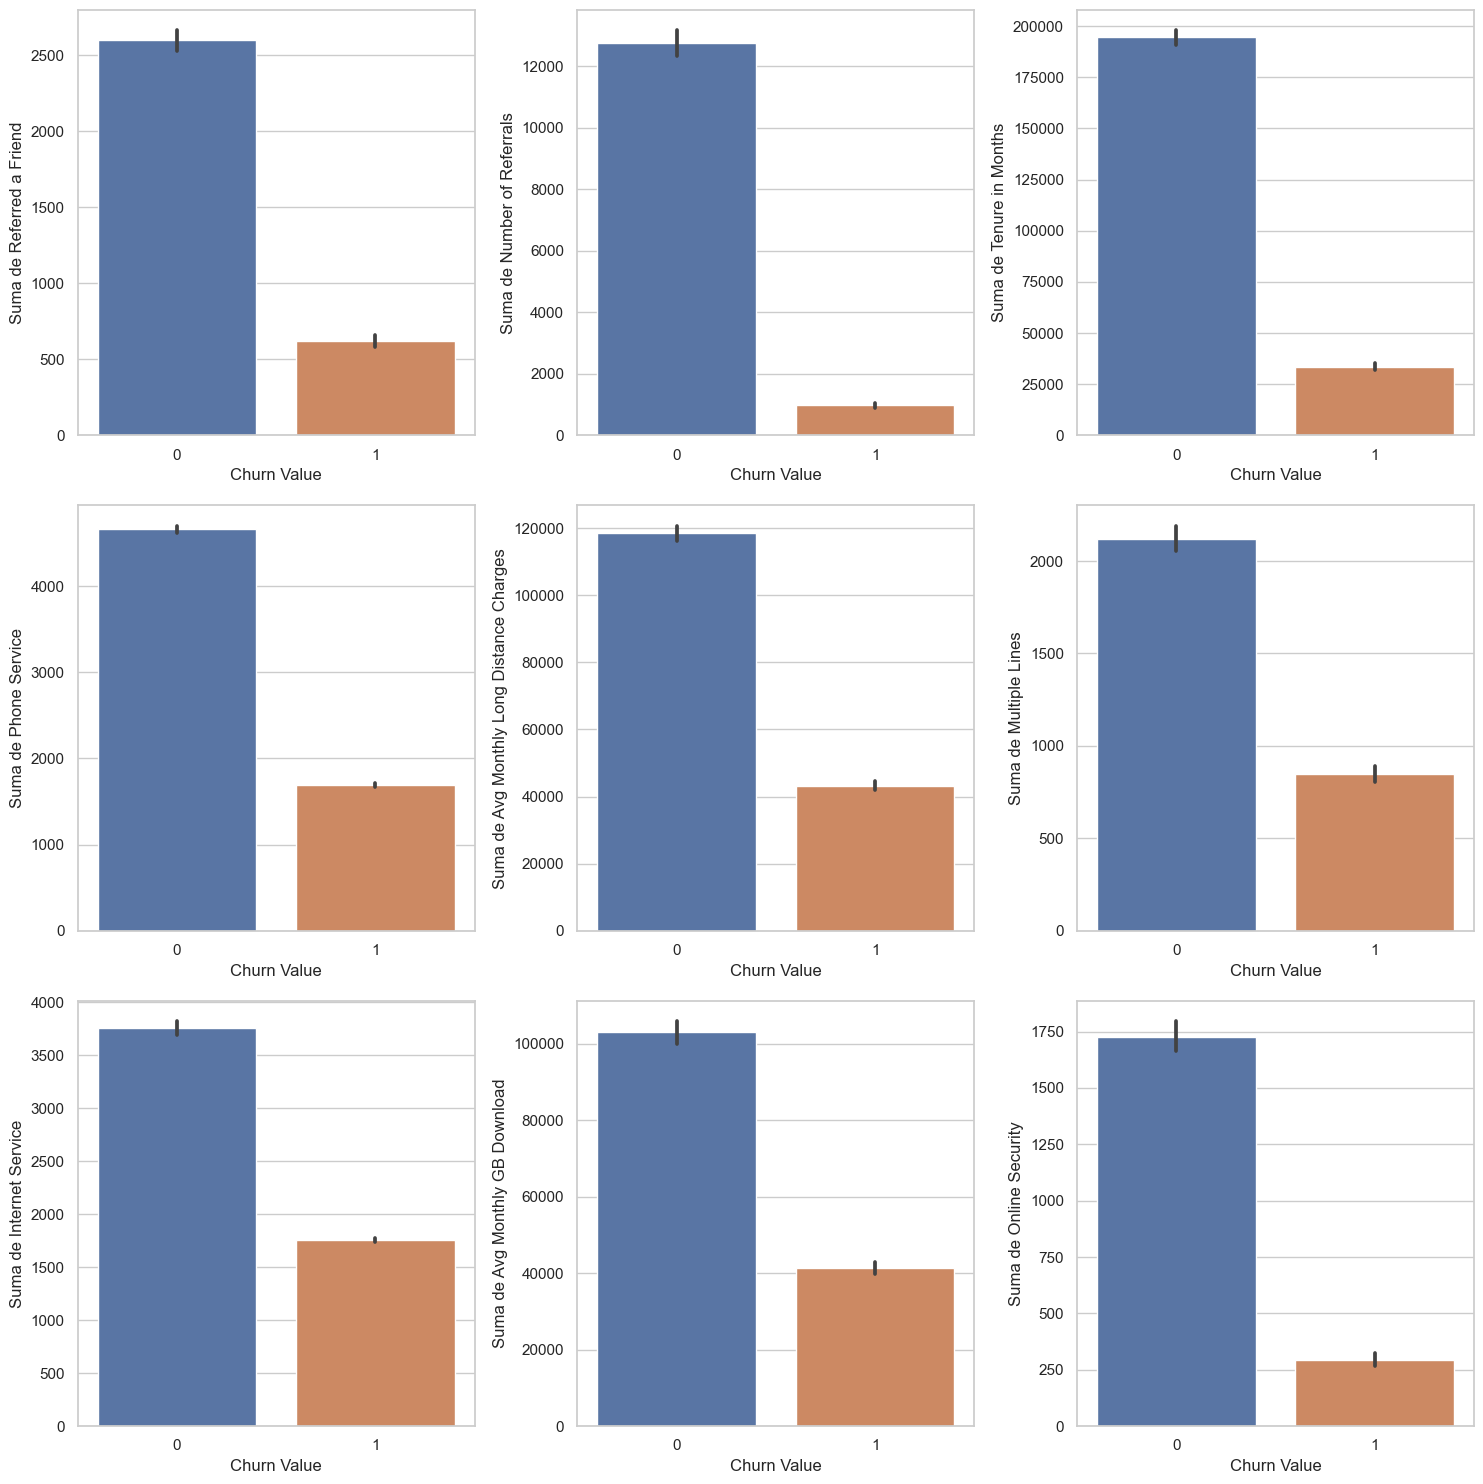

In [69]:

# Columnas a comparar con 'Churn Value'
columnas_a_comparar = ['Referred a Friend', 'Number of Referrals', 'Tenure in Months',
                       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
                       'Internet Service', 'Avg Monthly GB Download', 'Online Security']

# Dividir las columnas en grupos de 3
columnas_grupos = [columnas_a_comparar[i:i+3] for i in range(0, len(columnas_a_comparar), 3)]

# Generar múltiples gráficos
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, grupo in enumerate(columnas_grupos):
    for j, columna in enumerate(grupo):
        sns.barplot(x='Churn Value', y=columna, data=df, estimator=sum, ax=axs[i, j])
        axs[i, j].set_xlabel('Churn Value')
        axs[i, j].set_ylabel('Suma de {}'.format(columna))
        axs[i, j].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


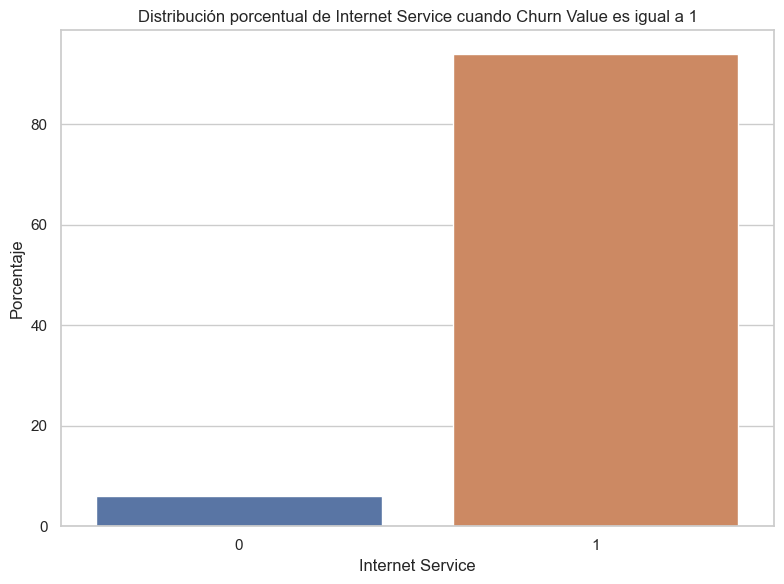

In [70]:
# Filtrar el DataFrame cuando 'Churn Value' es igual a 1
df_churn_1 = df[df['Churn Value'] == 1]

# Contar la frecuencia de cada categoría de 'Internet Service'
internet_service_counts = df_churn_1['Internet Service'].value_counts()

# Calcular los porcentajes
internet_service_percentages = (internet_service_counts / internet_service_counts.sum()) * 100

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=internet_service_percentages.index, y=internet_service_percentages.values)
plt.xlabel('Internet Service')
plt.ylabel('Porcentaje')
plt.title('Distribución porcentual de Internet Service cuando Churn Value es igual a 1')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


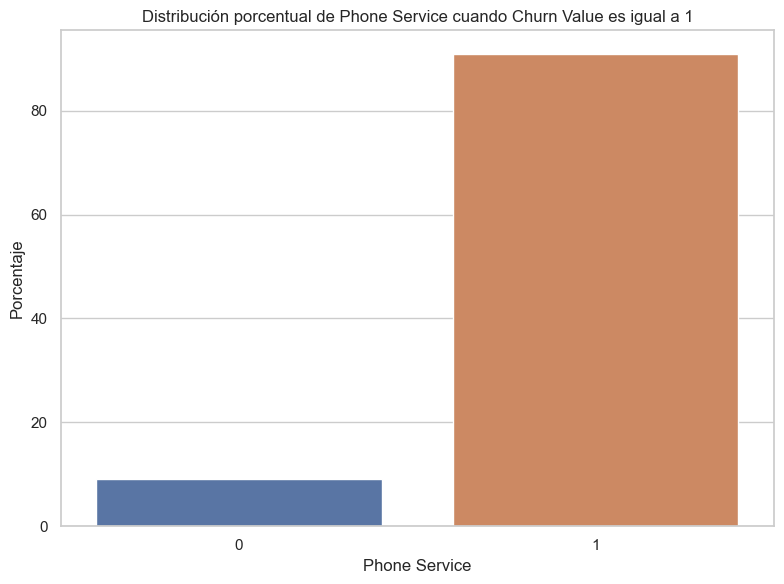

In [71]:
# Filtrar el DataFrame cuando 'Churn Value' es igual a 1
df_churn_1 = df[df['Churn Value'] == 1]

# Contar la frecuencia de cada categoría de 'Internet Service'
internet_service_counts = df_churn_1['Phone Service'].value_counts()

# Calcular los porcentajes
internet_service_percentages = (internet_service_counts / internet_service_counts.sum()) * 100

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=internet_service_percentages.index, y=internet_service_percentages.values)
plt.xlabel('Phone Service')
plt.ylabel('Porcentaje')
plt.title('Distribución porcentual de Phone Service cuando Churn Value es igual a 1')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Utilizando una agrupacion por GeoFips (Codigo postal de EEUU por Condado podemos ver en que zona se encuentra mayor cantidad de bajas). Se muestra que Los Angeles y Tijuana son las zonas con mayor cantidad de abandonos de Servicio.

In [72]:
import folium
# Filtrar el DataFrame para obtener filas donde 'Churn Value' es igual a 1
df_churn_1 = df[df['Churn Value'] == 1]
# Filtrar el DataFrame para obtener filas donde 'Churn Value' es igual a 0
df_churn_0 = df[df['Churn Value'] == 0]
# Calcular el promedio de latitud y longitud y la cantidad de 'Churn Value' agrupados por GeoFIPS
df_geo_avg_1 = df_churn_1.groupby('GeoFIPS').agg({'Latitude': 'mean', 'Longitude': 'mean', 'Churn Value': 'count'}).reset_index()
df_geo_avg_0 = df_churn_0.groupby('GeoFIPS').agg({'Latitude': 'mean', 'Longitude': 'mean', 'Churn Value': 'count'}).reset_index()
# Crear un mapa centrado en una ubicación inicial
mapa = folium.Map(location=[df['Latitude'].mean(), df['Longitude'].mean()], zoom_start=5)
# Escalar el tamaño de los círculos en función de la cantidad de 'Churn Value'
scale_factor = 0.09  # Puedes ajustar este factor de escala según tus necesidades
# Agregar círculos rojos proporcionales para 'Churn Value' = 1
for index, row in df_geo_avg_1.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=row['Churn Value'] * scale_factor, color='red', fill=True, fill_color='red').add_to(mapa)
# Agregar círculos azules proporcionales para 'Churn Value' = 0
for index, row in df_geo_avg_0.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=row['Churn Value'] * scale_factor, color='blue', fill=True, fill_color='blue').add_to(mapa)
# Mostrar el mapa
mapa


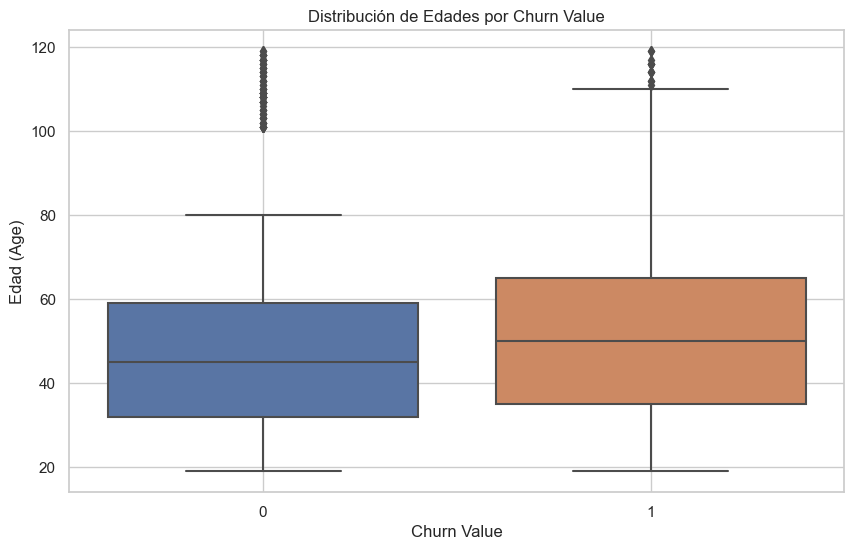

In [73]:
# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn Value', y='Age', data=df)

# Añadir etiquetas y título
plt.xlabel('Churn Value')
plt.ylabel('Edad (Age)')
plt.title('Distribución de Edades por Churn Value')

# Mostrar el gráfico
plt.grid(True)
plt.show()


In [74]:
# Calcula la mediana de la columna 'Age'
median_age = df['Age'].median()

# Reemplaza los valores mayores de 100 por la mediana
df.loc[df['Age'] >= 100, 'Age'] = median_age


In [75]:
# Calcula la mediana de la columna 'Monthly Charge'
median_monthly_charge = df['Monthly Charge'].median()

# Reemplaza los valores negativos con la mediana
df['Monthly Charge'] = df['Monthly Charge'].apply(lambda x: median_monthly_charge if x < 0 else x)

# Verifica que se hayan aplicado los cambios
print(df['Monthly Charge'].describe())  # Verifica estadísticas resumidas


count    7039.000000
mean       64.873526
std        29.859129
min        18.250000
25%        36.450000
50%        70.050000
75%        89.725000
max       118.750000
Name: Monthly Charge, dtype: float64


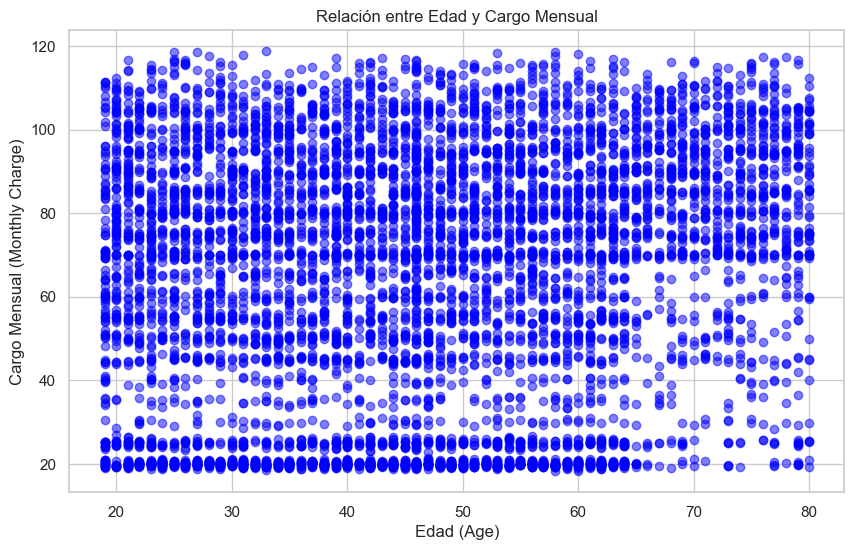

In [76]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['Monthly Charge'], alpha=0.5, color='blue')

# Añadir etiquetas y título
plt.xlabel('Edad (Age)')
plt.ylabel('Cargo Mensual (Monthly Charge)')
plt.title('Relación entre Edad y Cargo Mensual')

# Mostrar el gráfico
plt.grid(True)
plt.show()


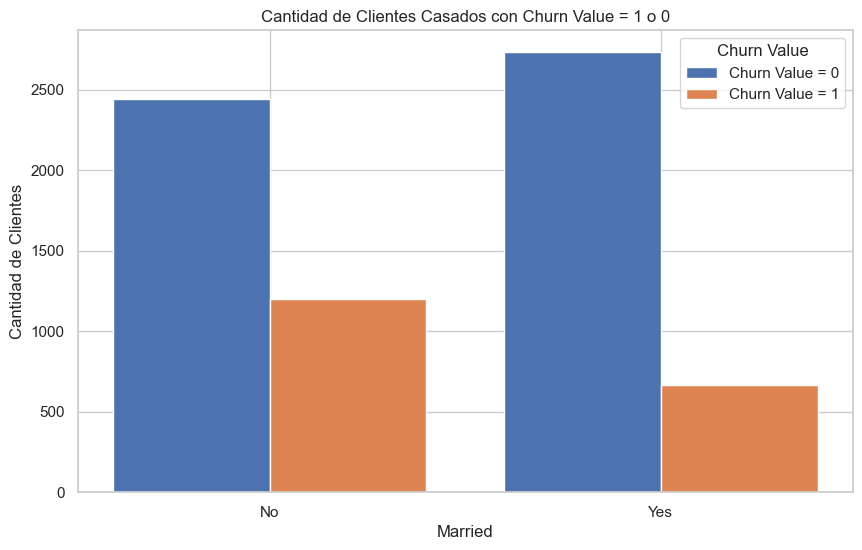

In [77]:
# Contar los valores de 'Married' para cada 'Churn Value'
married_churn_counts = df.groupby(['Married', 'Churn Value']).size().unstack()

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras para 'Churn Value' = 0
ax.bar(married_churn_counts.index - 0.2, married_churn_counts[0], width=0.4, label='Churn Value = 0')

# Crear barras para 'Churn Value' = 1
ax.bar(married_churn_counts.index + 0.2, married_churn_counts[1], width=0.4, label='Churn Value = 1')

# Añadir etiquetas y título
ax.set_xlabel('Married')
ax.set_ylabel('Cantidad de Clientes')
ax.set_title('Cantidad de Clientes Casados con Churn Value = 1 o 0')
ax.set_xticks(married_churn_counts.index)
ax.set_xticklabels(['No', 'Yes'])
ax.legend(title='Churn Value')

# Mostrar la gráfica
plt.show()


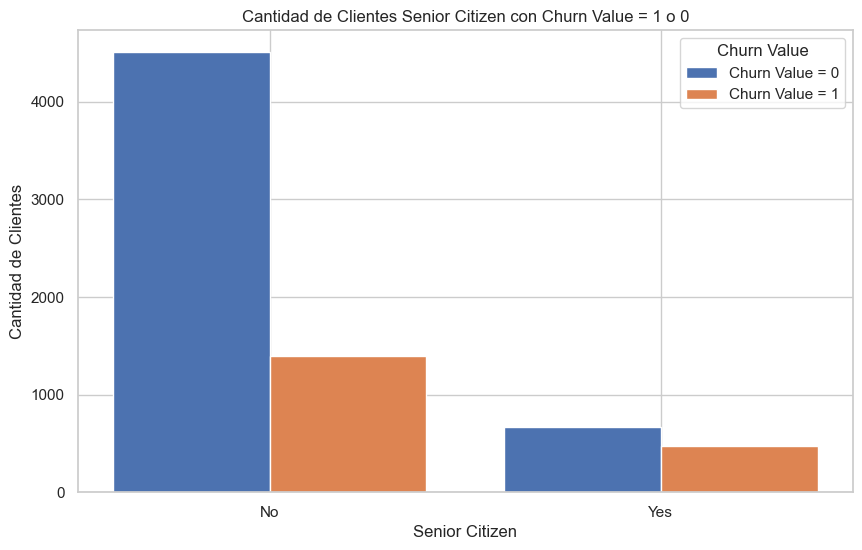

In [78]:
# Contar los valores de 'Senior Citizen' para cada 'Churn Value'
senior_citizen_churn_counts = df.groupby(['Senior Citizen', 'Churn Value']).size().unstack()

# Crear la gráfica de barras
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras para 'Senior Citizen' = 0
ax.bar(senior_citizen_churn_counts.index - 0.2, senior_citizen_churn_counts[0], width=0.4, label='Churn Value = 0')

# Crear barras para 'Senior Citizen' = 1
ax.bar(senior_citizen_churn_counts.index + 0.2, senior_citizen_churn_counts[1], width=0.4, label='Churn Value = 1')

# Añadir etiquetas y título
ax.set_xlabel('Senior Citizen')
ax.set_ylabel('Cantidad de Clientes')
ax.set_title('Cantidad de Clientes Senior Citizen con Churn Value = 1 o 0')
ax.set_xticks(senior_citizen_churn_counts.index)
ax.set_xticklabels(['No', 'Yes'])
ax.legend(title='Churn Value')

# Mostrar la gráfica
plt.show()


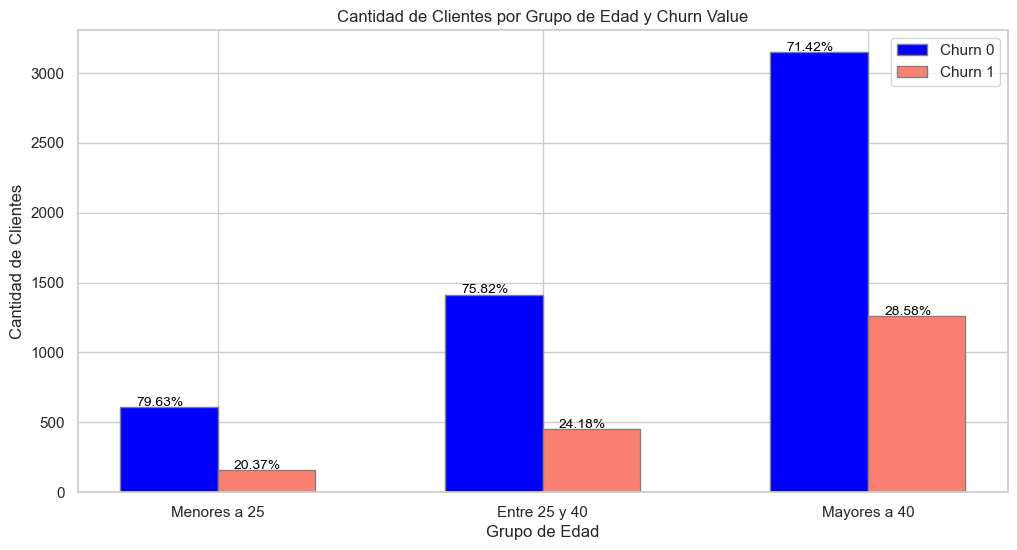

In [79]:
# Crear nuevos grupos de edades
bins = [0, 25, 40, float("inf")]
labels = ['Menores a 25', 'Entre 25 y 40', 'Mayores a 40']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Agrupar por nuevos grupos de edades y contar la cantidad de churn=0 y churn=1
grouped_df = df.groupby(['Age Group', 'Churn Value'])['Churn Value'].count().unstack().reset_index()
grouped_df.rename(columns={0: 'Churn 0', 1: 'Churn 1'}, inplace=True)

# Calcular porcentajes
grouped_df['Churn 0 (%)'] = grouped_df['Churn 0'] / (grouped_df['Churn 0'] + grouped_df['Churn 1']) * 100
grouped_df['Churn 1 (%)'] = grouped_df['Churn 1'] / (grouped_df['Churn 0'] + grouped_df['Churn 1']) * 100

# Graficar
barWidth = 0.3
r1 = range(len(grouped_df))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, grouped_df['Churn 0'], color='blue', width=barWidth, edgecolor='grey', label='Churn 0')
plt.bar(r2, grouped_df['Churn 1'], color='salmon', width=barWidth, edgecolor='grey', label='Churn 1')

# Agregar etiquetas de porcentajes
for i, r in enumerate(r1):
    plt.text(r - 0.1, grouped_df['Churn 0'][i] + 10, f"{grouped_df['Churn 0 (%)'][i]:.2f}%", color='black', fontsize=10)
    plt.text(r + barWidth - 0.1, grouped_df['Churn 1'][i] + 10, f"{grouped_df['Churn 1 (%)'][i]:.2f}%", color='black', fontsize=10)

plt.xlabel('Grupo de Edad')
plt.ylabel('Cantidad de Clientes')
plt.xticks([r + barWidth/2 for r in range(len(grouped_df))], grouped_df['Age Group'])
plt.title('Cantidad de Clientes por Grupo de Edad y Churn Value')
plt.legend()
plt.show()


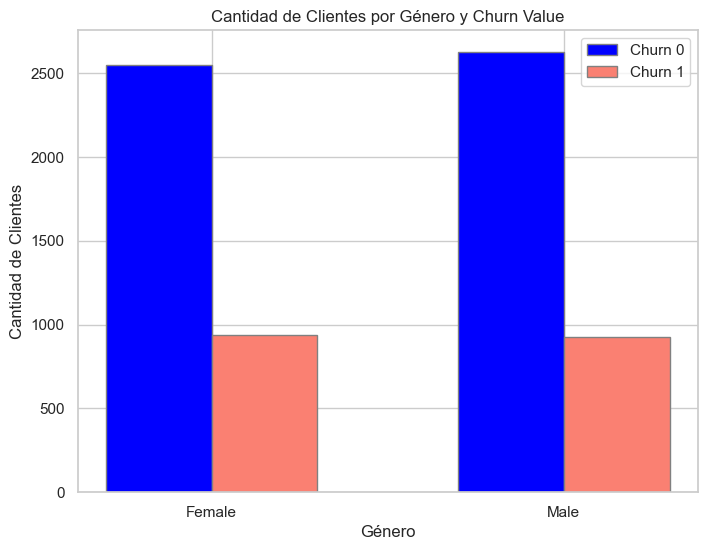

In [80]:
# Crear un diccionario para mapear los valores de 'Gender' a Male y Female
gender_map = {1: 'Male', 0: 'Female'}
df['Gender'] = df['Gender'].map(gender_map)

# Agrupar por género y contar la cantidad de churn=0 y churn=1
grouped_df = df.groupby(['Gender', 'Churn Value'])['Churn Value'].count().unstack().reset_index()
grouped_df.rename(columns={0: 'Churn 0', 1: 'Churn 1'}, inplace=True)

# Graficar
barWidth = 0.3
r1 = range(len(grouped_df))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(8, 6))
plt.bar(r1, grouped_df['Churn 0'], color='blue', width=barWidth, edgecolor='grey', label='Churn 0')
plt.bar(r2, grouped_df['Churn 1'], color='salmon', width=barWidth, edgecolor='grey', label='Churn 1')

plt.xlabel('Género')
plt.ylabel('Cantidad de Clientes')
plt.xticks([r + barWidth/2 for r in range(len(grouped_df))], grouped_df['Gender'])
plt.title('Cantidad de Clientes por Género y Churn Value')
plt.legend()
plt.show()


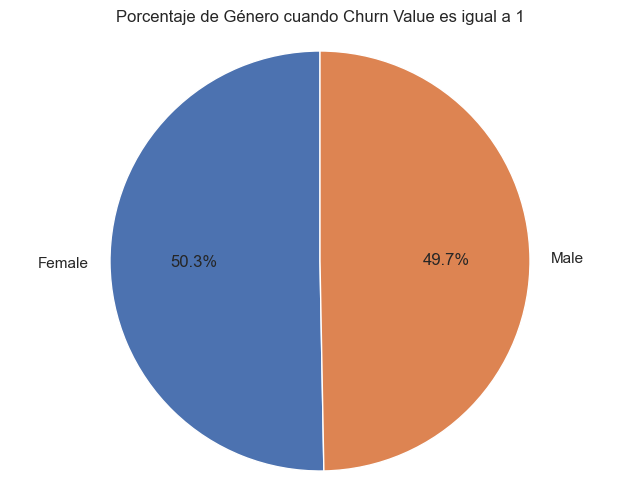

In [81]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por género
gender_counts = filtered_df['Gender'].value_counts()

# Graficar
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de Género cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


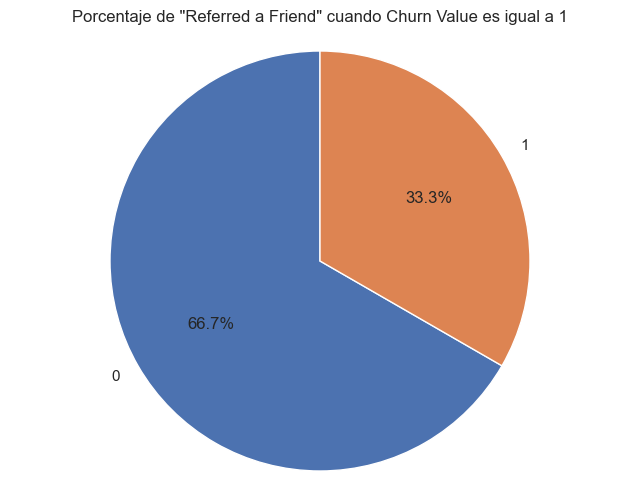

In [82]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por 'Referred a Friend' cuando es igual a 1
referred_counts = filtered_df['Referred a Friend'].value_counts()

# Graficar
plt.figure(figsize=(8, 6))
plt.pie(referred_counts, labels=referred_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Referred a Friend" cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


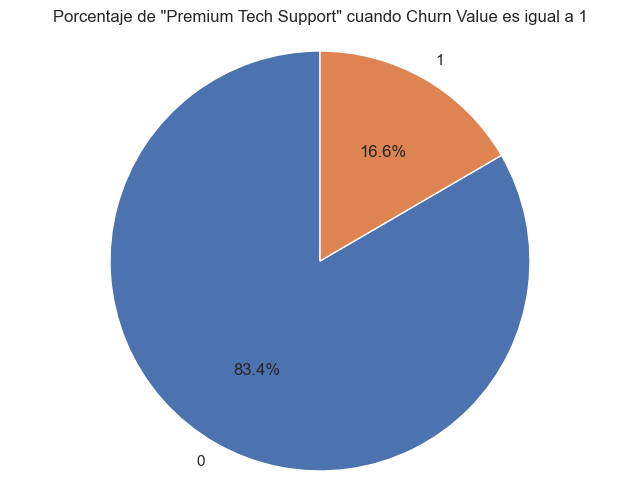

In [83]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por 'Premium Tech Support' cuando es igual a 1
tech_support_counts = filtered_df['Premium Tech Support'].value_counts()

# Graficar
plt.figure(figsize=(8, 6))
plt.pie(tech_support_counts, labels=tech_support_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Premium Tech Support" cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


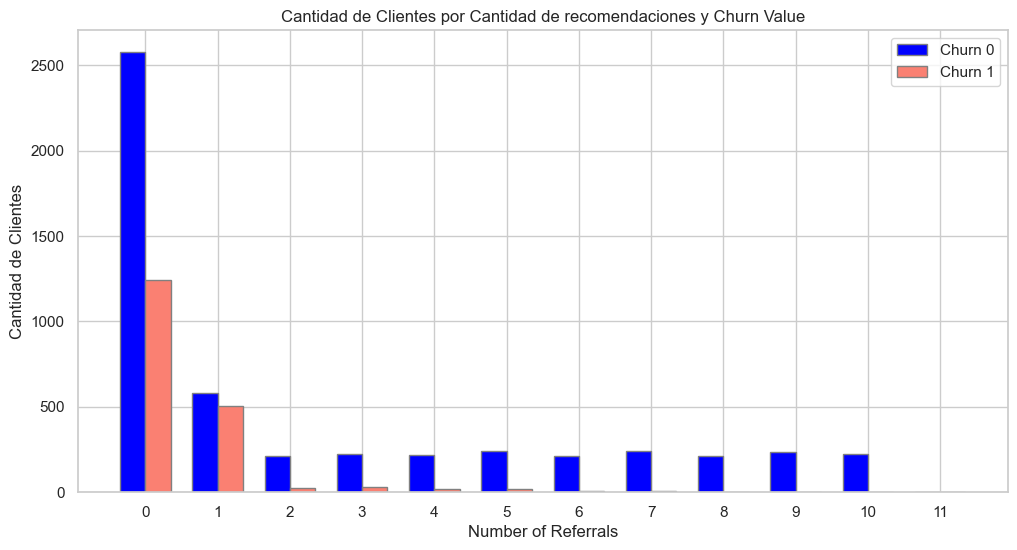

In [84]:
# Agrupar por 'Number of Referrals' y 'Churn Value' y contar la cantidad de casos
grouped_df = df.groupby(['Number of Referrals', 'Churn Value']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(12, 6))
barWidth = 0.35
r1 = range(len(grouped_df.index))
r2 = [x + barWidth for x in r1]

plt.bar(r1, grouped_df[0], color='blue', width=barWidth, edgecolor='grey', label='Churn 0')
plt.bar(r2, grouped_df[1], color='salmon', width=barWidth, edgecolor='grey', label='Churn 1')

plt.xlabel('Number of Referrals')
plt.ylabel('Cantidad de Clientes')
plt.xticks([r + barWidth/2 for r in range(len(grouped_df.index))], grouped_df.index)
plt.title('Cantidad de Clientes por Cantidad de recomendaciones y Churn Value')
plt.legend()
plt.show()


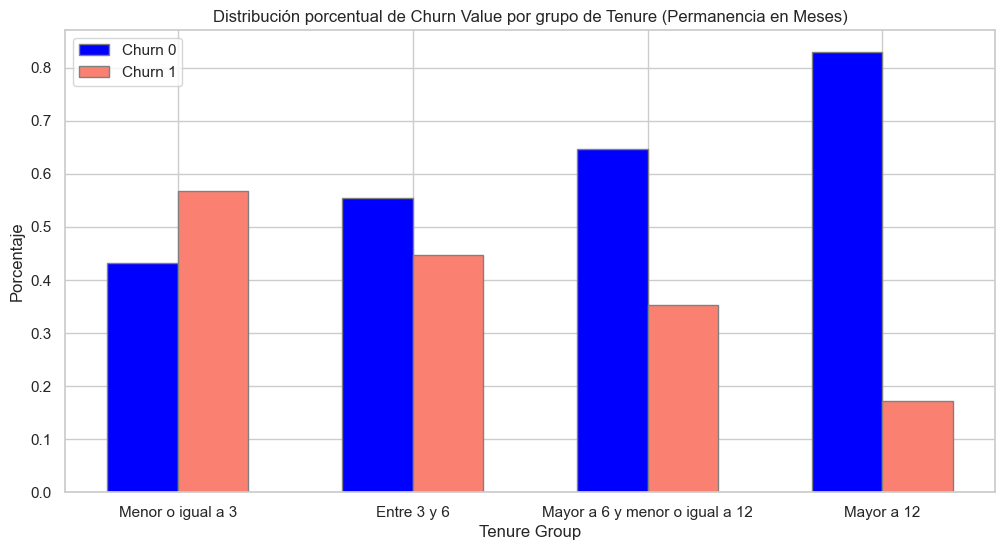

In [85]:

# Crear grupos adicionales en 'Tenure Group'
df['Tenure Group'] = pd.cut(df['Tenure in Months'], bins=[0, 3, 6, 12, float("inf")], labels=['Menor o igual a 3', 'Entre 3 y 6', 'Mayor a 6 y menor o igual a 12', 'Mayor a 12'])

# Calcular la distribución porcentual de Churn Value igual a 1 o 0 en cada grupo
grouped_df = df.groupby('Tenure Group')['Churn Value'].value_counts(normalize=True).unstack().reset_index()
grouped_df.rename(columns={0: 'Churn 0', 1: 'Churn 1'}, inplace=True)

# Graficar
barWidth = 0.3
r1 = range(len(grouped_df))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(12, 6))
plt.bar(r1, grouped_df['Churn 0'], color='blue', width=barWidth, edgecolor='grey', label='Churn 0')
plt.bar(r2, grouped_df['Churn 1'], color='salmon', width=barWidth, edgecolor='grey', label='Churn 1')

plt.xlabel('Tenure Group')
plt.ylabel('Porcentaje')
plt.xticks([r + barWidth/2 for r in range(len(grouped_df))], grouped_df['Tenure Group'])
plt.title('Distribución porcentual de Churn Value por grupo de Tenure (Permanencia en Meses)')
plt.legend()
plt.show()


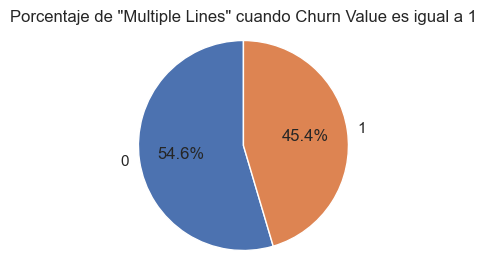

In [86]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por 'Multiple Lines' cuando es igual a 1
multiple_lines_counts = filtered_df['Multiple Lines'].value_counts()

# Graficar
plt.figure(figsize=(4,3))
plt.pie(multiple_lines_counts, labels=multiple_lines_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Multiple Lines" cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


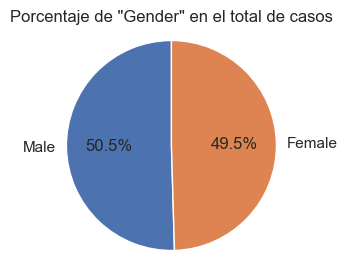

In [87]:
# Contar la cantidad de casos por 'Gender'
gender_counts = df['Gender'].value_counts(normalize=True)

# Graficar
plt.figure(figsize=(4,3))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Gender" en el total de casos')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


## Se marca una tendencia de personas casadas a abandonar el servicio en un 64.3%

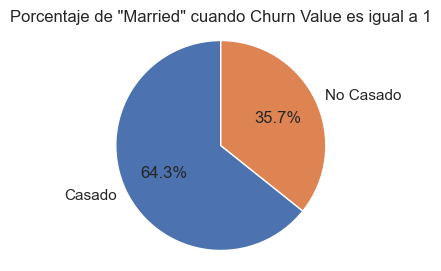

In [88]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por 'Married'
married_counts = filtered_df['Married'].value_counts(normalize=True)

# Graficar
plt.figure(figsize=(4, 3))
plt.pie(married_counts, labels=['Casado', 'No Casado'], autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Married" cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


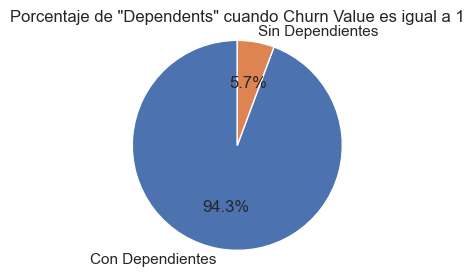

In [89]:
# Filtrar el DataFrame para obtener solo los casos donde Churn Value es igual a 1
filtered_df = df[df['Churn Value'] == 1]

# Contar la cantidad de casos por 'Dependents'
dependents_counts = filtered_df['Dependents'].value_counts(normalize=True)

# Graficar
plt.figure(figsize=(4, 3))
plt.pie(dependents_counts, labels=['Con Dependientes', 'Sin Dependientes'], autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de "Dependents" cuando Churn Value es igual a 1')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [90]:
# Eliminar las columnas especificadas
df.drop(columns=['Age Group', 'Tenure Group'], inplace=True)


In [91]:
# Reemplazar los valores de la columna 'Gender'
df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0})

# Normalizacion

In [92]:
# List of columns to normalize
columns_to_normalize = [
    'Zip Code', 'Latitude', 'Longitude', 'Population', 'GeoFIPS',
    'Per capita personal income (dollars)', 'Personal income (thousands of dollars)',
    'Farm proprietors\' income', 'Farm proprietors employment',
    'Per capita income maintenance benefits', 'Per capita retirement and other',
    'Per capita unemployment insurance compensation', 'Average nonfarm proprietors\' income',
    'Average wages and salaries', 'Monthly Charge', 'Total Charges', 'Total Refunds',
    'Total Extra Data Charges', 'Total Long Distance Charges', 'Tenure in Months',
    'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Age', 'Number of Dependents', 'Number of Referrals'
]

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Normalizar solo las columnas especificadas
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


# Mostrar las primeras filas del DataFrame normalizado para verificar
df.head()

,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,Online Backup,...,GeoFIPS,Per capita personal income (dollars),Personal income (thousands of dollars),Farm proprietors' income,Farm proprietors employment,Per capita income maintenance benefits,Per capita retirement and other,Per capita unemployment insurance compensation,Average nonfarm proprietors' income,Average wages and salaries
0,0,-0.650336,-1.279162,0,-1.486394,0,1,-0.612837,0,0,...,-0.687749,0.04278,1.953863,-0.476558,-0.39661,1.303072,0.366845,0.67983,-0.367656,0.217394
5,1,-0.317096,-0.993904,1,1.675728,1,1,-0.172143,0,1,...,-0.687749,0.04278,1.953863,-0.476558,-0.39661,1.303072,0.366845,0.67983,-0.367656,0.217394
10,0,-0.650336,-0.586392,1,-0.752989,1,1,1.541667,0,0,...,-0.687749,0.04278,1.953863,-0.476558,-0.39661,1.303072,0.366845,0.67983,-0.367656,0.217394
15,1,-0.317096,-0.301133,1,-0.207305,0,1,-0.416973,0,1,...,-0.687749,0.04278,1.953863,-0.476558,-0.39661,1.303072,0.366845,0.67983,-0.367656,0.217394
20,1,-0.317096,0.187882,1,-1.076645,1,1,-0.319041,0,0,...,-0.687749,0.04278,1.953863,-0.476558,-0.39661,1.303072,0.366845,0.67983,-0.367656,0.217394


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 0 to 38070
Data columns (total 80 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Referred a Friend                                       7039 non-null   int64  
 1   Number of Referrals                                     7039 non-null   float64
 2   Tenure in Months                                        7039 non-null   float64
 3   Phone Service                                           7039 non-null   int64  
 4   Avg Monthly Long Distance Charges                       7039 non-null   float64
 5   Multiple Lines                                          7039 non-null   int64  
 6   Internet Service                                        7039 non-null   int64  
 7   Avg Monthly GB Download                                 7039 non-null   float64
 8   Online Security                           

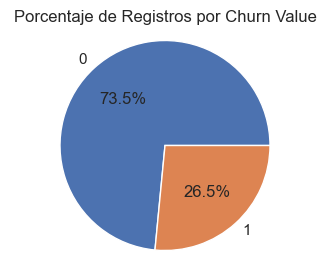

In [94]:

# Contar el número de registros con Churn Value igual a 1 y 0
churn_counts = df['Churn Value'].value_counts()

# Graficar el porcentaje de registros para cada Churn Value
plt.figure(figsize=(4, 3))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=0)
plt.title('Porcentaje de Registros por Churn Value')
plt.axis('equal')
plt.show()


## Generando Datos sinteticos con SMOTE


In [95]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Supongamos que tu DataFrame ya está cargado como 'df'

# Definir X y y
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE solo a los datos de entrenamiento
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convertir a DataFrame
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Churn Value')

# Concatenar para tener un DataFrame completo
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Separar características y variable objetivo
X_resampled = df_resampled.drop('Churn Value', axis=1)
y_resampled = df_resampled['Churn Value']

# Inicializar el modelo SVM
model = SVC(random_state=42)

# Entrenar el modelo
model.fit(X_resampled, y_resampled)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1550    2]
 [   8  552]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1552
           1       1.00      0.99      0.99       560

    accuracy                           1.00      2112
   macro avg       1.00      0.99      0.99      2112
weighted avg       1.00      1.00      1.00      2112



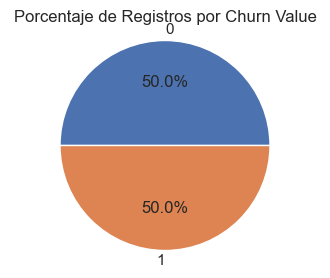

In [96]:
# Contar el número de registros con Churn Value igual a 1 y 0
churn_counts = df_resampled['Churn Value'].value_counts()

# Graficar el porcentaje de registros para cada Churn Value
plt.figure(figsize=(4, 3))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=0)
plt.title('Porcentaje de Registros por Churn Value')
plt.axis('equal')
plt.show()

## Regresion Logistica

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Supongamos que 'df_resampled' es tu DataFrame
# X son las características y y es la variable objetivo
X = df_resampled.drop('Churn Value', axis=1)
y = df_resampled['Churn Value']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador de Regresión Logística
logreg = LogisticRegression(max_iter=1000)

# Definir el rango de hiperparámetros a probar
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros: ", best_params)

# Entrenar el modelo con los mejores parámetros
best_logreg = grid_search.best_estimator_

# Predecir con los datos de prueba
y_pred = best_logreg.predict(X_test)

# Mostrar métricas de clasificación
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Mejores hiperparámetros:  {'C': 0.01, 'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       1.00      1.00      1.00       720

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448



## Support Vector Machine

In [99]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suponiendo que ya tienes tu df_resampled dividido en X e y
X = df_resampled.drop('Churn Value', axis=1)
y = df_resampled['Churn Value']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Definir los diferentes kernels a evaluar
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm_clf = SVC(kernel=kernel, random_state=40)
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    
    print(f"Resultados para el kernel '{kernel}':")
    print(classification_report(y_test, y_pred))
    print("-" * 50)


Resultados para el kernel 'linear':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       749

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448

--------------------------------------------------
Resultados para el kernel 'poly':
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       699
           1       0.99      1.00      1.00       749

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448

--------------------------------------------------
Resultados para el kernel 'rbf':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.0

## Arbol de decision

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

X = df_resampled.drop('Churn Value', axis=1)  # Features
y = df_resampled['Churn Value']  # Variable objetivo

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador de Árbol de Decisión
tree_clf = DecisionTreeClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],  # Función de medida de calidad de la división
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 10, 20],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 5, 10],  # Número mínimo de muestras en una hoja
    'max_features': [None, 'sqrt', 'log2']  # Número de características a considerar al buscar la mejor división
}

# Usar GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(estimator=tree_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar el modelo con los mejores hiperparámetros
best_tree_clf = grid_search.best_estimator_

# Predecir con los datos de prueba
y_pred = best_tree_clf.predict(X_test)

# Mostrar métricas de clasificación
print(classification_report(y_test, y_pred))


Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       1.00      1.00      1.00       720

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448



In [101]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separar las características (features) y la variable objetivo (target)
X = df_resampled.drop('Churn Value', axis=1)
y = df_resampled['Churn Value']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador del árbol de decisión
clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Realizar predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del modelo:")
print(accuracy_score(y_test, y_pred))


Matriz de Confusión:
[[728   0]
 [  0 720]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       1.00      1.00      1.00       720

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448


Precisión del modelo:
1.0


## Modelo Final a utlizar. Generacion del Archivo .pkl que contiene el algoritmo entrenado.

In [102]:
# Importar las bibliotecas necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Separar las características (features) y la variable objetivo (target)
X = df_resampled.drop('Churn Value', axis=1)
y = df_resampled['Churn Value']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el clasificador Gradient Boosting Machine (GBM)
gbm = GradientBoostingClassifier(random_state=42)

# Entrenar el modelo
gbm.fit(X_train, y_train)

# Realizar predicciones
y_pred = gbm.predict(X_test)

# Evaluar el modelo
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nPrecisión del modelo:")
print(accuracy_score(y_test, y_pred))


Matriz de Confusión:
[[728   0]
 [  0 720]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       1.00      1.00      1.00       720

    accuracy                           1.00      1448
   macro avg       1.00      1.00      1.00      1448
weighted avg       1.00      1.00      1.00      1448


Precisión del modelo:
1.0
